In [ ]:
import os
import random
from pathblib import Path

import string
import unicodedata

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_path = Path('/content/drive/MyDrive/colab_notebooks/data/text/names_by_countries')
files = sorted(os.listdir(dir_path))

In [ ]:
countries = [fname.split('.')[0] for fname in files]
n_countries = len(files)

country_to_label = {c:i for i,c in enumerate(countries)}
label_to_country = {i:c for i,c in enumerate(countries)}

print(n_countries, countries)

18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [ ]:
abc = list(" -'" + string.ascii_lowercase)
len_abc = len(abc)

itoc = {i:c for i,c in enumerate(abc)}
ctoi = {c:i for i,c in enumerate(abc)}

print(len_abc, abc)

29 [' ', '-', "'", 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
def encode(s: str) -> list[int]:
    return [ctoi[c] for c in s]

def decode(l: list[int]) -> str:
    return ''.join([itoc[i] for i in l])

def enc2seq(t: torch.Tensor) -> torch.Tensor:
    return F.one_hot(t, len_abc).float()

def unicode_to_ascii(s: str) -> str:
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in abc
    )

In [ ]:
X = []
Y = []

for fname in files:
    with open(Path(dir_path, fname), 'r') as file:
        names = file.read().splitlines()
        encodings = [encode(unicode_to_ascii(name)) for name in names]
        tensors = [torch.tensor(enc).long() for enc in encodings]
        label = country_to_label[fname.split('.')[0]]

        X.extend(tensors)
        Y.extend([label] * len(names))

X = torch.nn.utils.rnn.pad_sequence(X, batch_first=True, padding_side='left')
Y = torch.tensor(Y).long()

In [ ]:
print(X.shape)
print(Y.shape)

torch.Size([20047, 18])
torch.Size([20047])


In [ ]:
print(X[0], Y[0])
print(list(decode(X[0].tolist())), label_to_country[Y[0].item()])

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10, 17, 23, 20, 27]) tensor(0)
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'h', 'o', 'u', 'r', 'y'] Arabic


In [ ]:
class CharRNN(nn.Module):
    def __init__(self, n_in: int, n_h: int, n_out: int) -> None:
        super(CharRNN, self).__init__()

        self.rnn = nn.RNN(n_in, n_h, batch_first=True)
        self.linear = nn.Linear(n_h, n_out)
        self.lsm = nn.LogSoftmax(dim=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _, c = self.rnn(x)
        return self.lsm(self.linear(c[0]))

In [ ]:
loss_fn = nn.NLLLoss()
model = CharRNN(len_abc, 128, n_countries)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
n_epoch = 8
batch_size = 64

with torch.no_grad():
    print(loss_fn(model(enc2seq(X)), Y))

for epoch in range(n_epoch):
    batches = torch.split(torch.randperm(len(X)), batch_size)

    for batch in batches:
        optimizer.zero_grad()

        y_hat = model(enc2seq(X[batch]))
        loss_fn(y_hat, Y[batch]).backward()

        optimizer.step()

with torch.no_grad():
    print(loss_fn(model(enc2seq(X)), Y))

tensor(9.9065)
tensor(8.9914)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
confusion_matrix = torch.zeros(n_countries, n_countries)

Y_hat = model(enc2seq(X))
for y_hat, y in zip(Y_hat, Y):
    i = torch.argmax(y_hat).item()
    confusion_matrix[y.item()][i] += 1

for i in range(n_countries):
    confusion_matrix[i] /= torch.sum(confusion_matrix[i])

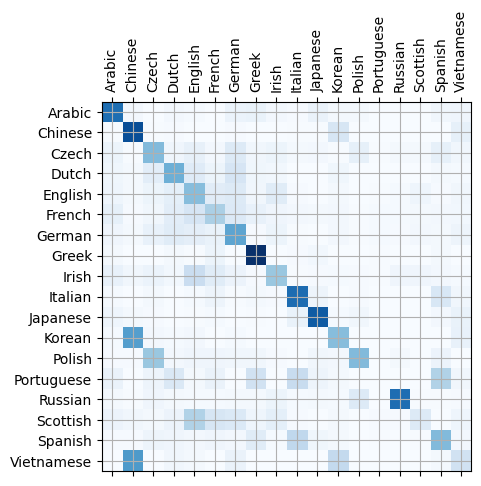

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.matshow(confusion_matrix, cmap='Blues')
ax.set_xticks(torch.arange(n_countries), labels=countries, rotation=90)
ax.set_yticks(torch.arange(n_countries), labels=countries)
ax.grid()

plt.show()